In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from time import time
from scipy.sparse import csr_matrix
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

#pd.set_op

In [38]:
nltk.download('stopwords')
stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vladimir\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 0. dataset

### 0.1. Echo Nest Taste

In [2]:
df1 = pd.read_csv("data/train_triplets.txt", sep="\t", header=None)
df1.columns = ['user_id', 'song_id', 'play_count']
df1.head()

,user_id,song_id,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1


In [7]:
df1.describe()

,play_count
count,4.837359e+07
mean,2.866859e+00
std,6.437725e+00
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,3.000000e+00
max,9.667000e+03


In [8]:
df1.isnull().sum()

user_id       0
song_id       0
play_count    0
dtype: int64

### 0.2. musiXmatch

In [67]:
mxm_tracks = {}
with open("data/mxm_dataset_train.txt") as f:
    lines = f.readlines()
    words = lines[17].replace('%', '').split(',')
    for i, line in list(enumerate(lines))[18:]:
        song_string = line.split(',')
        track_id = song_string[0]
        mxm_track_id = song_string[1]
        word_pair = [x.split(':') for x in song_string[2:]]
        dict = {}
        for word, count in word_pair:
            dict[int(word)] = int(count)
        word_lists = [[words[x-1]] * dict[x] for x in dict.keys()]
        song = [word for word_list in word_lists for word in word_list]
        song = [w for w in song if w not in stopwords]
        mxm_tracks[i-18] = {'track_id' : track_id, 'mxm_track_id': mxm_track_id, 'text': ' '.join(song)}
len(mxm_tracks)

210519

In [68]:
df2 = pd.DataFrame.from_dict(mxm_tracks).T
df2

,track_id,mxm_track_id,text
0,TRAAAAV128F421A322,4623710,like like de got would seem someon understand ...
1,TRAAABD128F429CF47,6477168,know know know know know time time time la la ...
2,TRAAAED128E0783FAB,2516445,love love love love love love love love love l...
3,TRAAAEF128F4273421,3759847,know got got got feel let would would would ey...
4,TRAAAEW128F42930C0,3783760,like take would wo someth stay burn burn burn ...
...,...,...,...
210514,TRZZZWS128F429CF87,3080645,que que que que que que que de en te te te te ...
210515,TRZZZXA128F428ED56,2344272,time la get eye think give dream wo wo head so...
210516,TRZZZXV128F4289747,1417347,know like like like time get get get never bac...
210517,TRZZZYV128F92E996D,6849828,get get get get get get get get get get get ge...


### 0.3. tagtraum

In [60]:
tag_tracks = {}
with open("data/p02_msd_tagtraum_cd2.cls") as f:
    lines = f.readlines()
    for i in range(7, len(lines)):
        line = lines[i].split('\t')
        track_id = line[0]
        majority_genre = line[1].replace('\n', "")
        try:
            minority_genre = line[2].replace('\n', "")
        except:
            minority_genre = np.nan
        tag_tracks[i-7] = {'track_id':track_id, 'majority_genre':majority_genre, "minority_genre":minority_genre}
len(tag_tracks)


280831

In [64]:
df3 = pd.DataFrame.from_dict(tag_tracks).T
df3

,track_id,majority_genre,minority_genre
0,TRAAAAK128F9318786,Rock,NaN
1,TRAAAAW128F429D538,Rap,NaN
2,TRAAABD128F429CF47,Rock,RnB
3,TRAAADJ128F4287B47,Rock,NaN
4,TRAAADZ128F9348C2E,Latin,NaN
...,...,...,...
280826,TRZZZRJ128F42819AF,Rock,NaN
280827,TRZZZUK128F92E3C60,Folk,NaN
280828,TRZZZYV128F92E996D,New Age,RnB
280829,TRZZZZD128F4236844,Rock,NaN


In [70]:
df23 = pd.merge(df2, df3, on='track_id', how='outer')
df23.head()

,track_id,mxm_track_id,text,majority_genre,minority_genre
0,TRAAAAV128F421A322,4623710,like like de got would seem someon understand ...,NaN,NaN
1,TRAAABD128F429CF47,6477168,know know know know know time time time la la ...,Rock,RnB
2,TRAAAED128E0783FAB,2516445,love love love love love love love love love l...,Jazz,NaN
3,TRAAAEF128F4273421,3759847,know got got got feel let would would would ey...,Rock,NaN
4,TRAAAEW128F42930C0,3783760,like take would wo someth stay burn burn burn ...,NaN,NaN


### 0.4. unique tracks

In [74]:
tracks = {}
with open("data/p02_unique_tracks.txt") as f:
    lines = f.readlines()
    for i in range(0, len(lines)):
        line = lines[i].split('<SEP>')
        track_id = line[0]
        song_id = line[1]
        artist = line[2]
        title = line[3].replace('\n', "")
        tracks[i] = {'track_id':track_id, 'song_id':song_id, "artist":artist,
        'title': title}
len(tracks)

1000000

In [75]:
df4 = pd.DataFrame.from_dict(tracks).T
df4

,track_id,song_id,artist,title
0,TRMMMYQ128F932D901,SOQMMHC12AB0180CB8,Faster Pussy cat,Silent Night
1,TRMMMKD128F425225D,SOVFVAK12A8C1350D9,Karkkiautomaatti,Tanssi vaan
2,TRMMMRX128F93187D9,SOGTUKN12AB017F4F1,Hudson Mohawke,No One Could Ever
3,TRMMMCH128F425532C,SOBNYVR12A8C13558C,Yerba Brava,Si Vos Querés
4,TRMMMWA128F426B589,SOHSBXH12A8C13B0DF,Der Mystic,Tangle Of Aspens
...,...,...,...,...
999995,TRYYYUS12903CD2DF0,SOTXAME12AB018F136,Kiko Navarro,O Samba Da Vida
999996,TRYYYJO128F426DA37,SOXQYIQ12A8C137FBB,Kuldeep Manak,Jago Chhadeo
999997,TRYYYMG128F4260ECA,SOHODZI12A8C137BB3,Gabriel Le Mar,Novemba
999998,TRYYYDJ128F9310A21,SOLXGOR12A81C21EB7,Elude,Faraday


In [83]:
df234 = pd.merge(df23, df4, on='track_id', how='outer')
print(df234.shape)
df234.head()

(1000000, 8)


,track_id,mxm_track_id,text,majority_genre,minority_genre,song_id,artist,title
0,TRAAAAV128F421A322,4623710,like like de got would seem someon understand ...,NaN,NaN,SOQPWCR12A6D4FB2A3,Western Addiction,A Poor Recipe For Civic Cohesion
1,TRAAABD128F429CF47,6477168,know know know know know time time time la la ...,Rock,RnB,SOCIWDW12A8C13D406,The Box Tops,Soul Deep
2,TRAAAED128E0783FAB,2516445,love love love love love love love love love l...,Jazz,NaN,SOXZYWX12A6310ED0C,Jamie Cullum,It's About Time
3,TRAAAEF128F4273421,3759847,know got got got feel let would would would ey...,Rock,NaN,SONHOTT12A8C13493C,Adam Ant,Something Girls
4,TRAAAEW128F42930C0,3783760,like take would wo someth stay burn burn burn ...,NaN,NaN,SODZYPO12A8C13A91E,Broken Spindles,Burn My Body (Album Version)


In [86]:
df234.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   track_id        1000000 non-null  object
 1   mxm_track_id    210519 non-null   object
 2   text            210519 non-null   object
 3   majority_genre  280831 non-null   object
 4   minority_genre  89430 non-null    object
 5   song_id         1000000 non-null  object
 6   artist          1000000 non-null  object
 7   title           1000000 non-null  object
dtypes: object(8)
memory usage: 68.7+ MB


In [89]:
# optimize memory by type casting
def optimize_memory(df):
    before, after = 0, 0
    for i in df.columns:
        before = before + df[i].memory_usage()
        if 'float64' == df[i].dtype or  'float32' == df[i].dtype:
            df[i] = df[i].astype('float16')
        if 'int64' == df[i].dtype or 'int32' == df[i].dtype:
            df[i] = df[i].astype('int16')
        after = after + df[i].memory_usage()

    before, after = before / 1024**2, after / 1024**2
    print("Before:\t{:.2f} Mb\nAfter:\t{:.2f} Mb".format(before, after))
    return df

df1 = optimize_memory(df1)
df2 = optimize_memory(df234)

Before:	1107.18 Mb
After:	830.39 Mb
Before:	122.07 Mb
After:	122.07 Mb


In [4]:
joblib.dump(df1, 'dump/df1.pkl')
joblib.dump(df2, 'dump/df2.pkl')

['dump/df1.pkl']

In [2]:
df1 = joblib.load("dump/df1.pkl")
df2 = joblib.load("dump/df2.pkl")

## 1. Top-250 songs 

In [3]:
ranged = df1.groupby('song_id').agg({'play_count': 'sum'}).sort_values('play_count', ascending = False)
ranged[:250].reset_index().merge(df2, on="song_id", how ='inner')\
    [['artist', 'title', 'play_count']]



,artist,title,play_count
0,Dwight Yoakam,You're The One,726885
1,Björk,Undo,648239
2,Kings Of Leon,Revelry,527893
3,Harmonia,Sehr kosmisch,425463
4,Barry Tuckwell/Academy of St Martin-in-the-Fie...,Horn Concerto No. 4 in E flat K495: II. Romanc...,389880
...,...,...,...
262,Triple Six Mafia,Now I'm High_ Really High,35253
263,The Red Jumpsuit Apparatus,Face Down (Album Version),35245
264,Linkin Park,New Divide (Album Version),35191
265,Selena Gomez & The Scene,Naturally,35074


## 2. Top-100 songs by genre

In [38]:
genre = ranged.reset_index().merge(df2, on="song_id", how ='left')
def g_filter(g):
    return genre[genre.majority_genre == g][:100].reset_index().drop('index', axis=1)[['artist', 'title', 'play_count']]

In [42]:
genre_dict = {
    'Rock': g_filter('Rock'),
    'Rap': g_filter('Rap'),
    'Jazz': g_filter('Jazz'),
    'Electronic': g_filter('Electronic'),
    'Pop': g_filter('Pop'),
    'Blues': g_filter('Blues'),
    'Country': g_filter('Country'),
    'Reggae': g_filter('Reggae'),
    'New Age': g_filter('New Age')
}

In [41]:
genre_dict['Rock']

,artist,title,play_count
0,Björk,Undo,648239
1,Kings Of Leon,Revelry,527893
2,Harmonia,Sehr kosmisch,425463
3,OneRepublic,Secrets,292642
4,Tub Ring,Invalid,268353
...,...,...,...
95,Metric,Gold Guns Girls,28148
96,Pearl Jam,Encore Break,27579
97,Daughtry,No Surprise,27187
98,Eric Clapton,Tears In Heaven,26999


In [43]:
genre_dict['Rap'] # check last 5

,artist,title,play_count
0,Alliance Ethnik,Représente,241669
1,Beastie Boys,The Maestro,72381
2,Eminem,Without Me,63918
3,Black Eyed Peas,Imma Be,62438
4,Kid Cudi,Up Up & Away,59810
...,...,...,...
95,Kid Cudi / Ratatat,Alive (nightmare),7508
96,Shwayze,Buzzin',7384
97,Orishas,El Kilo,7324
98,Snoop Dogg,Sexual Eruption,7171


In [44]:
genre_dict['Jazz']

,artist,title,play_count
0,Ron Carter,I CAN'T GET STARTED,158636
1,Jacky Terrasson,Le Jardin d'Hiver,75540
2,Erin Bode,Here_ There And Everywhere,43298
3,Michael Bublé,Home (Album Version),28314
4,Bohren & Der Club Of Gore,Welk,24673
...,...,...,...
95,Jamie Cullum,Photograph,2237
96,MFSB,Freddie's Dead,2221
97,Koop,Tonight,2167
98,Art Pepper,Mambo De La Pinta,2161


## 1.3. Collections
#### love, war, happiness

In [34]:
# baseline
lyrics = ranged.reset_index().merge(df2, on="song_id", how ='left')\
    .dropna(subset=['text'])

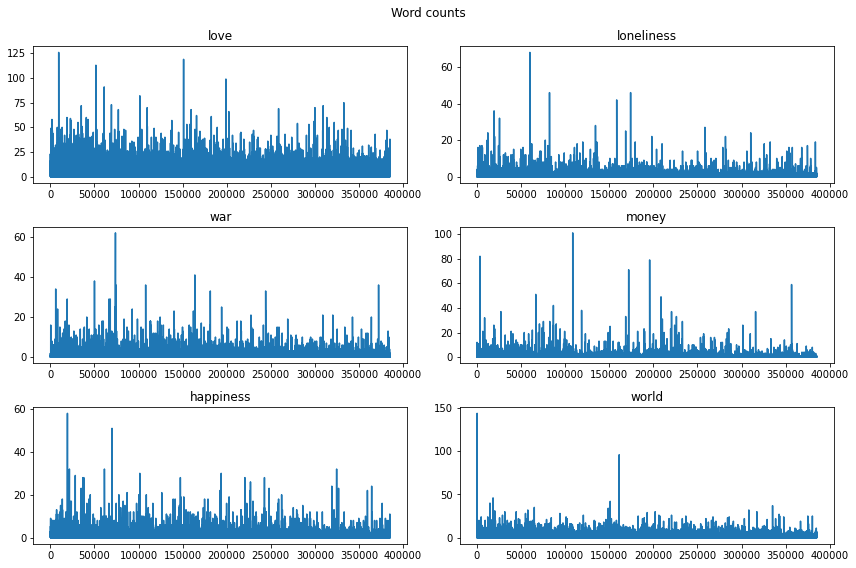

In [35]:
fig, axs = plt.subplots( 3, 2, figsize=(12,8))
lyrics['text'].str.count('love').plot(ax=axs[0][0])
lyrics['text'].str.count('war').plot(ax=axs[1][0])
lyrics['text'].str.count('happ*').plot(ax=axs[2][0])
lyrics['text'].str.count('lonel*').plot(ax=axs[0][1])
lyrics['text'].str.count('money').plot(ax=axs[1][1])
lyrics['text'].str.count('world').plot(ax=axs[2][1])
fig.suptitle('Word counts')
axs[0][0].set_title('love')
axs[1][0].set_title('war')
axs[2][0].set_title('happiness')
axs[0][1].set_title('loneliness')
axs[1][1].set_title('money')
axs[2][1].set_title('world')
fig.tight_layout()

In [46]:
lyrics_baseline = {'love':lyrics[lyrics['text'].str.count('love') > 3][['artist', 'title', 'play_count']][:50].reset_index(drop=True),
'war':lyrics[lyrics['text'].str.count('war') > 0][['artist', 'title', 'play_count']][:50].reset_index(drop=True),
'happiness':lyrics[lyrics['text'].str.count('happ*') > 0][['artist', 'title', 'play_count']][:50].reset_index(drop=True),
'loneliness':lyrics[lyrics['text'].str.count('lonel*') > 0][['artist', 'title', 'play_count']][:50].reset_index(drop=True)}

In [47]:
# maybe sort?
lyrics_baseline['love']

,artist,title,play_count
0,Sam Cooke,Ain't Misbehavin,244730
1,Bill Withers,Make Love To Your Mind,146978
2,Randy Crawford,Almaz,129868
3,Lady GaGa,Alejandro,111615
4,Taylor Swift,Love Story,89589
5,John Mayer,Heartbreak Warfare,87745
6,Rise Against,Savior,74654
7,Sean Kingston and Justin Bieber,Eenie Meenie,66998
8,John Mayer,Half Of My Heart,65966
9,Eagles,Hotel California,65585


## 1.4. People similar to you listen

In [3]:
tmp2 = df2.drop_duplicates(subset='song_id', keep='first')[['song_id',  'artist', 'title']]

sims = pd.merge(df1, tmp2)
sims

,user_id,song_id,play_count,artist,title
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,Jack Johnson,The Cove
1,7c86176941718984fed11b7c0674ff04c029b480,SOAKIMP12A8C130995,1,Jack Johnson,The Cove
2,76235885b32c4e8c82760c340dc54f9b608d7d7e,SOAKIMP12A8C130995,3,Jack Johnson,The Cove
3,250c0fa2a77bc6695046e7c47882ecd85c42d748,SOAKIMP12A8C130995,1,Jack Johnson,The Cove
4,3f73f44560e822344b0fb7c6b463869743eb9860,SOAKIMP12A8C130995,6,Jack Johnson,The Cove
...,...,...,...,...,...
48373581,7e5ee985d8df64ef746a8c374357d7f39ccfcb61,SOJLGCD12A6D4F4A7C,1,Fad Gadget,The Ring
48373582,ac96070188fa5618d5e1595937f6e02b4ab4a4fa,SONYEUK12A8C13E9A4,1,Joe Veras,Mi Dueña
48373583,b691b8eda35349ebaf4801c5c56a399273b6157c,SOUSSCZ12A8C131D83,2,Rez Band,Concert For A Queen
48373584,12bce146f59c4e6d32e1a460468197cfd7cf14e8,SOKSHWF12AB018B8CC,3,Tim Rushlow,Then There's Me (LP Version)


In [108]:
# just for my slow memeory
sims = sims[:10000]

In [4]:
def create_matrix(df):
    user_u = df['user_id'].unique()
    song_u = df['song_id'].unique()
    N = len(user_u)
    M = len(song_u)
    user_mapper = dict(zip(user_u, list(range(N))))
    song_mapper = dict(zip(song_u, list(range(M))))
    user_inv_mapper = dict(zip(list(range(N)), user_u))
    song_inv_mapper = dict(zip(list(range(N)), song_u))
    user_index = [user_mapper[i] for i in df['user_id']]
    song_index = [song_mapper[i] for i in df['song_id']]
    user_play_matrix = csr_matrix((df['play_count'], (user_index, song_index)), shape=(N, M))
    song_play_matrix = csr_matrix((df['play_count'], (song_index, user_index)), shape=(M, N))
    return user_play_matrix, song_play_matrix, user_mapper, song_mapper, user_inv_mapper, song_inv_mapper

- csr - Compressed Sparse Row matrix (Сжатая разреженная колонна), enables fast matrix vector products
    - the sparse matrix is the best data structure to represent the commonly used user-item matrix. 
    - because the user*product matrix is a very large sparse matrix with a small percentage of it filled in
    - the goal of recommendation is to predict empty rows
    - filling empty space with rows would be waste of memory and create zero-inflation
    - numpy.sparse has 7 types of sparse matrices
    - csr_matrix is good for row-wise slicing and like csc_matrix, fast for arithmetic operations including +, -, *, /, power ** and matrix multiplication @. csr_matrix is also not efficient when adding a new element to the data.

In [5]:
def pak(actual, predicted, k=10):
    # k - the max number of predicted elements
    # score - average precision at k over the input list
    score = 0.0
    num_hits = 0.0
    if len(predicted) > k:
        predicted = predicted[:k]
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    if not actual:
        return 0.0
    return score / min(len(actual), k)

p@k (precision at k)
- the metrcs to assess accuracy of recommendation
- the percentage of the correct recommendations from your list
- f.e. 3 sons liked from 10 recommended - 30% pak
- the average p@k for your recommendations should be at least greater than 10%

In [6]:
def fit_model(X, k=10):
    k+=1
    model = NearestNeighbors(n_neighbors=k, algorithm="brute", metric='cosine', n_jobs=-1)
    model.fit(X)
    return model

In [87]:
user_play_matrix, song_play_matrix, user_mapper, song_mapper, user_inv_mapper, song_inv_mapper = create_matrix(sims[:10000])
song_titles = dict(zip(sims.song_id, sims.title))
model1 = fit_model(user_play_matrix, 20)

In [173]:
# remove own id????
def find_similar_users(model, user_id, user_play_matrix, k, user_mapper, user_inv_mapper, df):
    neighbour_ids = [] # most similar users
    user_vec = user_play_matrix[user_mapper[user_id]]
    neighbour = model.kneighbors(user_vec, return_distance=False)
    for i in range(0, k+1):
        n = neighbour.item(i)
        neighbour_ids.append(user_inv_mapper[n])
    neighbour_ids.remove(user_id)
    #first = neighbour_ids[:5]
    #second = neighbour_ids[5:]
    chart = df[df['user_id'].isin(neighbour_ids)]\
        [['song_id', 'play_count']].groupby('song_id').sum()\
        .sort_values(by=[('play_count')], ascending=False).index.to_list()

    """ what the hell is that???
    res = new_df[:7]
    j = res.index.to_list()
    new_df = df[df['user_id'].isin(second)][['song_id', 'play_count']].groupby('song_id')\
        [~new_df.index.isin(j)].sort_values(by=[('play_count', 'sum')], inplace = True, ascending = False)
    res = pd.concat([res, new_df[:(10 - len(res))]])
    return res.index.to_list() """
    return chart


In [174]:
user_id= 'b80344d063b5ccb3212f76538f3d9e43d87dca9e'
sim_ids = find_similar_users(model1, user_id, user_play_matrix, 20, user_mapper, user_inv_mapper, sims)
sim_ids

['SOBBMDR12A8C13253B',
 'SOBSUJE12A6D4F8CF5',
 'SOAKIMP12A8C130995',
 'SOAPDEY12A81C210A9',
 'SOBFNSP12AF72A0E22',
 'SOBVFZR12A6D4F8AE3',
 'SOBXHDL12A81C204C0']

In [175]:
known_ids = set(sims[sims['user_id'] == 'b80344d063b5ccb3212f76538f3d9e43d87dca9e'].song_id.to_list())
pak(list(known_ids), sim_ids)

0.7

In [176]:
a = sims[sims['user_id'] == 'b80344d063b5ccb3212f76538f3d9e43d87dca9e'].title.to_list()
b = []
[b.append(song_titles[i]) for i in known_ids]
pd.DataFrame({'initial user songs':a, 'similar users songs':b})

,initial user songs,similar users songs
0,The Cove,Sin límites (I)
1,Nothing from Nothing,Entre Dos Aguas
2,Entre Dos Aguas,Riot Radio (Soundtrack Version)
3,Under Cold Blue Stars,Nothing from Nothing
4,Riot Radio (Soundtrack Version),Ears To The Ground (Album Version)
5,Sin límites (I),Stronger
6,12 segundos de oscuridad,The Cove
7,Ears To The Ground (Album Version),Food Chain (Album Version)
8,Food Chain (Album Version),12 segundos de oscuridad
9,Stronger,Under Cold Blue Stars


In [ ]:
joblib.dump(model1, 'dump/model_task4.pkl')

### 1.5. who listen to this track usually listen

In [201]:
def find_similar_songs(model, song_id, song_play_matrix, k, song_mapper, song_inv_mapper):
    neighbour_ids = [] # most similar users
    song_vec = song_play_matrix[song_mapper[song_id]]
    neighbour = model.kneighbors(song_vec, return_distance=False)
    for i in range(0, k+1):
        n = neighbour[0].item(i)
        neighbour_ids.append(song_inv_mapper[n])
    neighbour_ids.remove(song_id)
    return neighbour_ids

In [193]:
model2 = fit_model(song_play_matrix, 20)

In [202]:
song_id = 'SOAKIMP12A8C130995'
sim_ids = find_similar_songs(model2, song_id, song_play_matrix, 10, song_mapper, song_inv_mapper)
sim_ids

TypeError: sparse matrix length is ambiguous; use getnnz() or shape[0]

In [178]:
sims

,user_id,song_id,play_count,artist,title
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,Jack Johnson,The Cove
1,7c86176941718984fed11b7c0674ff04c029b480,SOAKIMP12A8C130995,1,Jack Johnson,The Cove
2,76235885b32c4e8c82760c340dc54f9b608d7d7e,SOAKIMP12A8C130995,3,Jack Johnson,The Cove
3,250c0fa2a77bc6695046e7c47882ecd85c42d748,SOAKIMP12A8C130995,1,Jack Johnson,The Cove
4,3f73f44560e822344b0fb7c6b463869743eb9860,SOAKIMP12A8C130995,6,Jack Johnson,The Cove
...,...,...,...,...,...
9995,40f36f44412c55db0831c49122ac496e3072ab69,SOBXHDL12A81C204C0,1,Kanye West,Stronger
9996,7ada7be344af59dffaf109c4f16d1b222c380ec7,SOBXHDL12A81C204C0,1,Kanye West,Stronger
9997,e68446a4eb9e1cc28d923ae0a3c9aab11817b914,SOBXHDL12A81C204C0,2,Kanye West,Stronger
9998,6d523d97cffd9e2982d64547aa554a5dc724d654,SOBXHDL12A81C204C0,1,Kanye West,Stronger
